In [64]:

import scipy
import pandas as pd
import random
import portpy.photon as pp
import numpy as np
from cvxpy import *
from scipy import sparse
import sklearn.metrics
import cProfile
import time
import sys
import psutil
from sklearn.decomposition import PCA
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear
import scipy.sparse


In [4]:

data_dir = r'../data'
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Phantom_Patient_1'
data.patient_id = patient_id
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
opt_params = data.load_config_opt_params(protocol_name='Lung_2Gy_30Fx')
structs.create_opt_structures(opt_params)
inf_matrix_sparse = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name)
plan_sparse = pp.Plan(ct, structs, beams, inf_matrix_sparse, clinical_criteria)
opt = pp.Optimization(plan_sparse, opt_params=opt_params)
opt.create_cvxpy_problem()

sol_sparse = opt.solve(solver='MOSEK', verbose=True)
dose_sparse_1d = plan_sparse.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions())
x_sparse =sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions()

beams_dense = pp.Beams(data, load_inf_matrix_full=True)
inf_matrix_dense = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_dense, is_full=True)
plan_dense = pp.Plan(ct, structs, beams, inf_matrix_dense, clinical_criteria)
dose_dense_1d = plan_dense.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_dense.get_num_of_fractions())
A_dense = plan_dense.inf_matrix.A
# sparse_tol = plan_sparse.inf_matrix.sparse_tol
#print(sol_sparse['problem_value'])


creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done
                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Sep 11 01:32:43 PM: Your problem has 1946 variables, 110663 constraints, and 0 parameters.
(CVXPY) Sep 11 01:32:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 11 01:32:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 11 01:32:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 11 01:32:44 PM: Your problem is compiled with the CPP canonicalization backend.
------------------------------------

In [6]:
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix

def matrix_sparsification(A, epsilon, verbose=False):
    """
    Matrix Sparsification Algorithm
    
    Parameters:
    A (numpy.ndarray): The input matrix of size n x n.
    epsilon (float): Accuracy parameter.
    verbose (bool): If True, print detailed steps.
    
    Returns:
    scipy.sparse.csr_matrix: The sparsified matrix.
    """
    m, n = A.shape
    
    # Step 1: Zero-out small entries
    threshold = epsilon / (2.0 * n)
    A_tilde = np.copy(A)
    A_tilde[np.abs(A_tilde) < threshold] = 0
    
    if verbose:
        print(f"Threshold for zero-out: {threshold}")
        print("A_tilde after zero-out:\n", A_tilde)
    
    # Step 2: Set s
    fro_norm_A_tilde = np.linalg.norm(A_tilde, 'fro')
    s = int((28 * n * np.log(n * np.sqrt(2 *n)) / (epsilon**2)) * (fro_norm_A_tilde**2))
    
    if verbose:
        print(f"Frobenius norm of A_tilde: {fro_norm_A_tilde}")
        print(f"Number of samples (s): {s}")
    
    # Step 3: Randomly sample indices
    p_ij = (A_tilde**2) / fro_norm_A_tilde**2
    flattened_indices = np.arange(m * n)
    sampled_indices = np.random.choice(flattened_indices, size=s, p=p_ij.flatten())
    
    row_indices = sampled_indices // n
    col_indices = sampled_indices % n
    
    if verbose:
        print("Sampled row indices:\n", row_indices)
        print("Sampled col indices:\n", col_indices)
    
    # Step 4: Construct the approximated matrix
    A_hat_data = A_tilde[row_indices, col_indices] / p_ij[row_indices, col_indices]
    A_hat_data /= s
    A_hat = csr_matrix((A_hat_data, (row_indices, col_indices)), shape=(m, n)).tocsr()
    
    if verbose:
        print("A_hat after construction:\n", A_hat)
    
    return A_hat



In [8]:

m,n = A_dense.shape
d = m*n
epsilon = 0.9900

start_time = time.time()

A_sparsified = matrix_sparsification(A_dense, epsilon, verbose=False)

end_time = time.time()

total_execution_time = end_time - start_time
print(f" Matrix Build Runtime : {total_execution_time} Second")


 Matrix Build Runtime : 4460.680576324463 Second


In [12]:
m,n = A_dense.shape
d = m*n
m,n = A_sparsified.shape
d2 = m*n

nonzero_count = (np.count_nonzero(A_dense))/d
print("nnz A Matrix: ", nonzero_count)

# Count non-zero entries in the sparsified matrix
nnz_S = (A_sparsified.nnz)/d2
print("nnz sparsified matrix:", nnz_S)

nnz A Matrix:  0.3151234981768092
nnz sparsified matrix: 0.0516048745054521


In [14]:
A_hat = A_sparsified
A = A_dense
p = dose_dense_1d
print(f'A_hat = {A_hat.shape}\nA = {A_dense.shape}\np = {p.shape}')

A_hat = (60183, 542)
A = (60183, 542)
p = (60183,)


<center> 
Minimize $\lVert A^* x - p \rVert_{2}^2$
</center>
<center> 
 p = دوزتجویزی
</center>

                                                           

In [19]:
start_time = time.time()

sol_ls_A_sparse = scipy.sparse.linalg.lsqr(A_hat, p)

end_time = time.time()
total_execution_time = end_time - start_time
print(f"Total execution time of the sparse matrix LS \t: {total_execution_time} Second")



Total execution time of the sparse matrix LS 	: 0.9418549537658691 Second


In [21]:
##  Examination of matrix sparsification
is_sparse = sparse.issparse(A_hat)
is_sparse

True

In [25]:
sol_ls_A_dense = scipy.sparse.linalg.lsqr(A_dense, dose_sparse_1d)
x_A_dense = sol_ls_A_dense[0]
error = x_A_dense - x_sparse 
error[0:6]

array([-2.85523274, -2.06709019, -1.95530732, -2.43994748, -2.38719333,
       -1.54658055])

In [26]:
print(f'x_sparse = {x_sparse.shape}\tx_A_dense = {x_A_dense.shape}\tp = {p.shape}')
print(f'\nx_sparse = {x_sparse.ndim}\tx_A_dense = {x_A_dense.ndim}\tp = {p.ndim}')

x_sparse = (542,)	x_A_dense = (542,)	p = (60183,)

x_sparse = 1	x_A_dense = 1	p = 1


In [29]:
x_sparse = sol_ls_A_sparse[0]
print(f'x_sparse :\t {x_sparse[0:6]}')


x_sparse :	 [ 7.01575734  0.54675514  0.30466842  0.38351193 14.90265652  7.6188924 ]


In [31]:
cost = cp.sum_squares((A @ x_A_dense  - A @ x_sparse  )/ cp.norm(A @ x_A_dense))
prob = cp.Problem(Minimize(cost))
prob.solve()

0.03840220560900765

In [33]:
cost = cp.sum_squares((A @ x_sparse - p )/ cp.norm(p))
prob_2 = cp.Problem(Minimize(cost))
prob_2.solve(solver='MOSEK', verbose=True)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Sep 11 03:01:47 PM: Your problem has 0 variables, 0 constraints, and 0 parameters.
(CVXPY) Sep 11 03:01:47 PM: It is compliant with the following grammars: DCP, DGP, DQCP
(CVXPY) Sep 11 03:01:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 11 03:01:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 11 03:01:47 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 11 03:01:47 PM: Compiling problem (target solver=CONSTAN

0.0004950128165940973

In [35]:

x_A_dense = sol_ls_A_dense[0]
print(f'x_A_dense :\t {x_A_dense[0:4]}')

cost = cp.norm(A @ x_A_dense - A @ x_sparse, "fro")/ cp.norm(A @ x_A_dense, "fro")

prob = cp.Problem(cp.Minimize(cost))
 
prob.solve()


x_A_dense :	 [ 3.67488051 -1.8787341  -1.95530416 -2.43994502]


0.19596480706751315

In [37]:
x_sparse = sol_ls_A_sparse[0]
cost = sum_squares(A @ x_sparse -  p)
prob_original = Problem(Minimize(cost))
prob_original.solve()

5706.186647521602

In [39]:
cost = cp.sum_squares(A_hat @ x_sparse -  p)
prob = cp.Problem(Minimize(cost))
prob.solve()

8713.224891708158

In [41]:
def calculate_relative_error(vector1, vector2):
   
    array1 = np.array(x_A_dense)
    array2 = np.array(x_sparse)

    norm_vector2 = np.linalg.norm(x_A_dense)

    relative_error = np.linalg.norm(array1 - array2) / norm_vector2

    return relative_error

error = calculate_relative_error(x_A_dense, x_sparse)
print(f"Relative error: {error}")


Relative error: 0.18062511720573346


In [43]:

def calculate_absolute_error(vector1, vector2):
    array1 = np.array(x_A_dense)
    array2 = np.array(x_sparse)

    absolute_error = np.linalg.norm(array1 - array2, ord=1) 

    return absolute_error


error = calculate_absolute_error(x_A_dense, x_sparse)
print(f"Absolute Error: {error}")


Absolute Error: 730.5638416071884


In [45]:
## MSE = Mean Squared Error

d_true = p          # (prescription) Actual Dose 
d_pred = A @ x_sparse   # Predicted Dose

MSE = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE)



Mean Squared Error : 0.09481392831067913


In [47]:
# Mean Squared Error

d_true = A @ x_A_dense         
d_pred = A @ x_sparse  

MSE = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE)


Mean Squared Error : 5.4323706210108424


In [49]:
memory_usage_sol_ls_sparse = sys.getsizeof(sol_ls_A_sparse )
megabyte_size_sol_ls_sparse = memory_usage_sol_ls_sparse / 1024 / 1024

print(f"Memory sol_ls_A_sparse : {megabyte_size_sol_ls_sparse} MB")

Memory sol_ls_A_sparse : 0.00011444091796875 MB


In [53]:
memory_usage_A_hat = sys.getsizeof(A_hat)
megabyte_size_A_hat= memory_usage_A_hat / 1024 / 1024

print(f"Memory A_hat : {megabyte_size_A_hat} MB")

Memory A_hat : 5.340576171875e-05 MB


<center> 
Minimize $\lVert Ax - p \rVert_{2}^2$
</center>
<center>
subject to $x \succeq 0$
</center>
<center>
p = دوزتجویزی
</center>


In [68]:
start_time = time.time()

# Solving the LS Problem with  Constant  x>=0
sol_dense_con = lsq_linear (A, p, bounds=(0, np.inf))

end_time = time.time ()

total_execution_time = end_time - start_time
print(f"Time to solve the problem Sol_dense: {total_execution_time} Second")


Time to solve the problem Sol_dense: 1.3824543952941895 Second


In [70]:
# In this problem, the unconstrained solution is also optimal.
# sol_dense.message: 'The unconstrained solution is optimal.'
sol_dense_con

       message: The unconstrained solution is optimal.
       success: True
        status: 3
           fun: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
             x: [ 6.530e+00  1.884e-01 ...  3.678e-06  3.540e+00]
           nit: 0
          cost: 4.624375278197093e-23
    optimality: 1.1475319910957398e-11
   active_mask: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
 unbounded_sol: (array([ 6.530e+00,  1.884e-01, ...,  3.678e-06,  3.540e+00]), array([ 7.547e-23]), 542, array([ 2.014e+01,  1.663e+01, ...,  1.636e+00,  1.373e+00]))

In [72]:
start_time = time.time()

# Solving the LS Problem with  Constant - x>=0
sol_sparse_con = lsq_linear (A_hat ,  p, bounds=(0, np.inf))

end_time = time.time()

total_execution_time = end_time - start_time
print(f"Time to solve the problem Sol_sparse: {total_execution_time} Second")


Time to solve the problem Sol_sparse: 58.60578179359436 Second


In [74]:
sol_sparse_con

       message: The relative change of the cost function is less than `tol`.
       success: True
        status: 2
           fun: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
             x: [ 7.011e+00  5.462e-01 ...  3.026e-02  4.160e+00]
           nit: 8
          cost: 4356.957506857213
    optimality: 2.4942509192315263e-08
   active_mask: [0 0 ... 0 0]
 unbounded_sol: (array([ 7.016e+00,  5.468e-01, ...,  7.257e-02,  4.154e+00]), 2, 92, 93.34465646370825, 6.908479367491754e-09, 97.26453188193372, 4.495676916837934, 231.37394019310196)

   ## DVH Plot

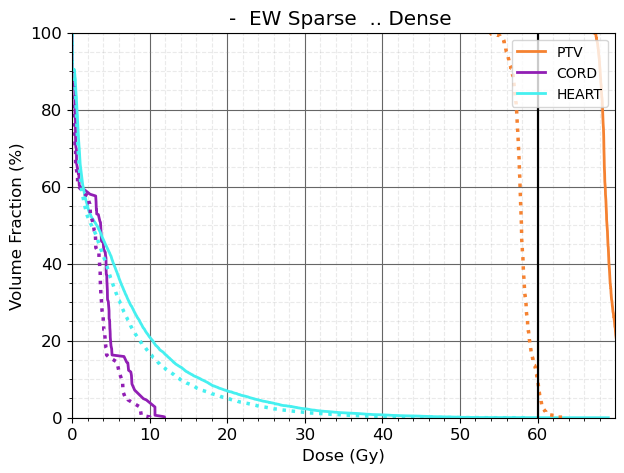

Done!


In [85]:
#  DVH

dose_dense = plan_dense.inf_matrix.A @ x_A_dense
dose_sparse = plan_dense.inf_matrix.A @ x_sparse

fig, ax = plt.subplots(figsize=(7, 5))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
ax = pp.Visualization.plot_dvh(plan_dense, dose_1d=dose_sparse, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(plan_dense, dose_1d=dose_dense, struct_names=struct_names, style='dotted', ax=ax)
ax.set_title('-  EW Sparse  .. Dense ')
plt.show()
print('Done!')

In [87]:

dose_sparse_df = pd.DataFrame(dose_sparse)

description = dose_sparse_df.describe()
print(description)


                  0
count  60183.000000
mean       6.674670
std       12.443227
min        0.000000
25%        0.352807
50%        1.406160
75%        6.652810
max       75.166410


In [89]:
# Norm Frobenius

cost = cp.norm(A_dense  - A_hat , "fro")

prob = cp.Problem(cp.Minimize(cost))

prob.solve()


4.6030544014422725

In [91]:
# Norm Frobenius

cost = cp.norm(A_dense  - A_hat , "fro")/ cp.norm(A_dense , "fro")

prob = cp.Problem(cp.Minimize(cost))

prob.solve()


0.03538347769759582